In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [3]:
df = load_pkl('../data/feat_engin/lgbm/data_1hour_1day.pkl')
df["income_rate"] = np.maximum(df["income_rate"], 0.97)
df["income_rate"] = np.minimum(df["income_rate"], 1.05)

In [5]:
df.shape

(971600, 682)

In [106]:
df['result'].value_counts(normalize=True)

result
LOSE    0.400563
DNF     0.342511
WIN     0.256926
Name: proportion, dtype: float64

In [112]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.970000
0.01    0.970000
0.10    0.970000
0.20    0.970000
0.30    0.970000
0.40    0.970000
0.50    0.995276
0.60    1.009394
0.70    1.028605
0.80    1.050000
0.90    1.050000
0.99    1.050000
1.00    1.050000
Name: income_rate, dtype: float64

In [10]:
# Используем уже знакомую функцию :)

def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: 
        mask_val_first = np.array(df['close'] > val_first)      ### тут будущему мне поразбираться нужно будет
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        income_rate = res_price/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        income_rate = res_price/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        income_rate = res_price/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            income_rate = res_price/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            income_rate = res_price/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })
    return df_result    

In [823]:
inds = np.arange(df.shape[0])
inds.shape

(971600,)

In [2015]:
df_result = get_df_target(df, inds, percent_first=0.98, percent_second=1.04, points_to_wait=14*2)

100%|███████████████████████████████████████████████████████████████| 971600/971600 [05:47<00:00, 2799.76it/s]


In [2016]:
df_result["income_rate"] = np.maximum(df_result["income_rate"], 0.98)
df_result["income_rate"] = np.minimum(df_result["income_rate"], 1.04)

In [2017]:
df_result['result'].value_counts(normalize=True)

result
DNF     0.469792
LOSE    0.362681
WIN     0.167527
Name: proportion, dtype: float64

In [2018]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.980000
0.01    0.980000
0.10    0.980000
0.20    0.980000
0.30    0.980000
0.40    0.987900
0.50    0.996741
0.60    1.003665
0.70    1.012187
0.80    1.026575
0.90    1.040000
0.99    1.040000
1.00    1.040000
Name: income_rate, dtype: float64

In [2057]:
(df_result['ind'] == df_result.index).all(), 

(True,)

In [2059]:
(df_result['time'] == df['time']).all(), (df_result['close'] == df['close']).all()

(True, True)

In [2061]:
#union
df = pd.concat([df[df.columns[~df.columns.isin(['result', 'delta_time', 'income_rate', 'res_price', 'res_ind'])]],
                df_result[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']]], axis=1)
df

,time,close,volume,ticker,tmos_close,index_1day,close_w1_roc,close_w1_diff,volume_w1_roc,volume_w1_diff,...,volume_1day_w100_min/volume_1day_w100_max,tmos_close_1day_w100_min/tmos_close_1day_w100_max,target,ticker_code,y_pred,result,delta_time,income_rate,res_price,res_ind
0,2022-05-04 18:00:00,31.200001,43918.0,AFLT,4.18,0.0,-0.000641,-0.020,-0.110107,-5434.0,...,1.000000,1.000000,0,3,None,LOSE,1 days 16:00:00,0.980000,30.379999,10
1,2022-05-05 10:00:00,31.240000,124578.0,AFLT,4.22,0.0,0.001282,0.040,1.836605,80660.0,...,1.000000,1.000000,0,3,None,LOSE,1 days 00:00:00,0.980000,30.379999,10
2,2022-05-05 11:00:00,30.980000,94771.0,AFLT,4.21,0.0,-0.008323,-0.260,-0.239264,-29807.0,...,1.000000,1.000000,0,3,None,LOSE,1 days 01:00:00,0.980000,30.280001,12
3,2022-05-05 12:00:00,30.920000,35215.0,AFLT,4.22,0.0,-0.001937,-0.060,-0.628420,-59556.0,...,1.000000,1.000000,0,3,None,LOSE,1 days 00:00:00,0.980000,30.280001,12
4,2022-05-05 13:00:00,30.920000,30094.0,AFLT,4.23,0.0,0.000000,0.000,-0.145421,-5121.0,...,1.000000,1.000000,0,3,None,LOSE,0 days 23:00:00,0.980000,30.280001,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971595,2024-12-31 19:00:00,10.830000,6.0,RBCM,6.27,85511.0,0.002778,0.030,-0.907692,-59.0,...,0.012193,0.832536,0,85,None,DNF,0 days 04:00:00,0.994460,10.770000,971599
971596,2024-12-31 20:00:00,10.775000,1.0,RBCM,6.27,85511.0,-0.005078,-0.055,-0.833333,-5.0,...,0.012193,0.832536,0,85,None,DNF,0 days 03:00:00,0.999536,10.770000,971599
971597,2024-12-31 21:00:00,10.820000,10.0,RBCM,6.27,85511.0,0.004176,0.045,9.000000,9.0,...,0.012193,0.832536,0,85,None,DNF,0 days 02:00:00,0.995379,10.770000,971599
971598,2024-12-31 22:00:00,10.765000,59.0,RBCM,6.27,85511.0,-0.005083,-0.055,4.900000,49.0,...,0.012193,0.832536,0,85,None,DNF,0 days 01:00:00,1.000464,10.770000,971599


### 1. train/valid/test/test2 split

In [7]:
df['target'] = (df['result'] == 'WIN').astype(int)

<Axes: xlabel='time'>

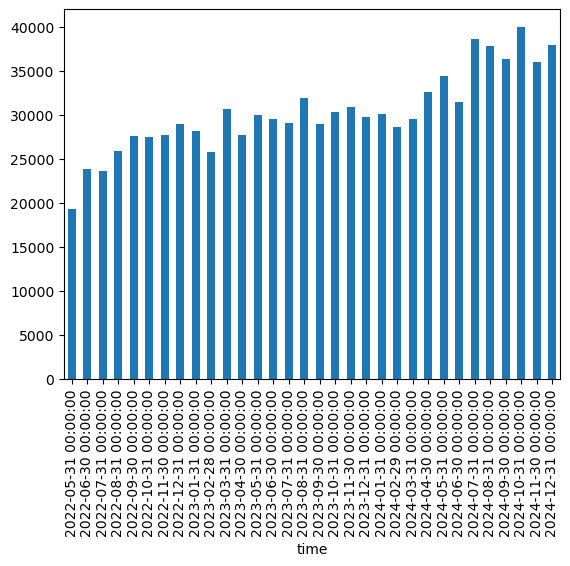

In [9]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.count().plot.bar()

<Axes: xlabel='time'>

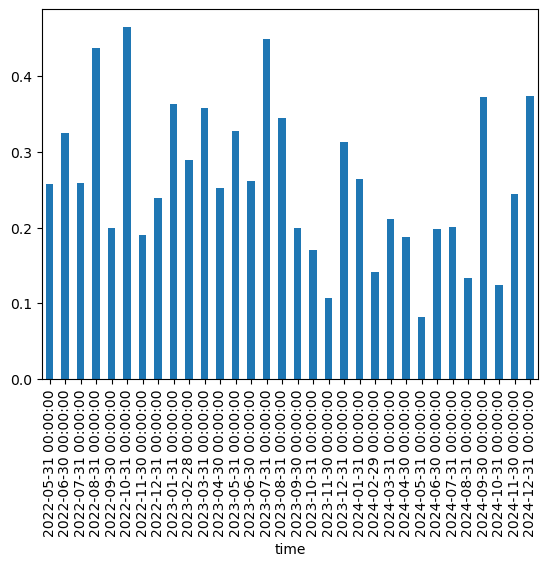

In [10]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

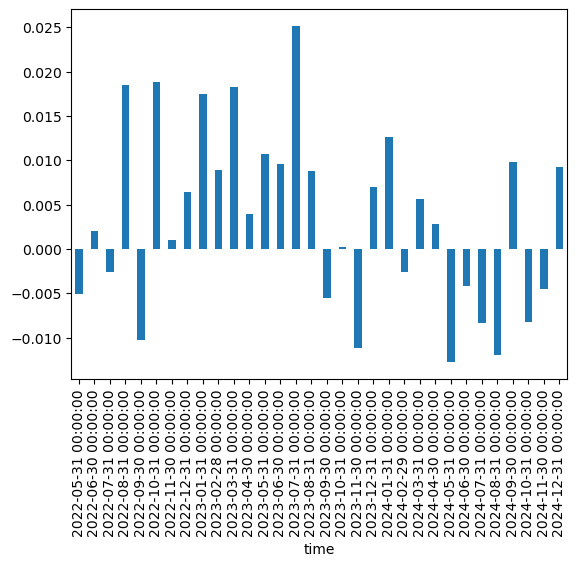

In [12]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [16]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-07-01')))
mask_valid = np.array((pd.Timestamp('2024-07-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-09-01')))
mask_test = np.array((pd.Timestamp('2024-09-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-11-01')))
mask_test2 = np.array((pd.Timestamp('2024-11-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-12-23')))
#mask_test2 = mask_test

In [18]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(744713, 76495, 76398, 61912)

In [21]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 102
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all


#мб дату неправильно обрезаю

In [22]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(627417, 76495, 76398, 61912)

In [23]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

842222

In [24]:
df.loc[mask_data].isnull().sum()[df.loc[mask_data].isnull().sum() > 0].sort_values()

Series([], dtype: int64)

In [27]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7449544181937778,
 0.09082522185362055,
 0.0907100503192745,
 0.07351030963332708)

In [28]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.25620918782882834,
 0.16759265311458266,
 0.2425194376816147,
 0.2882801395529138)

In [29]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0054965, 0.9898568, 1.0003895, 0.9985952)

In [31]:
#проверки

In [32]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

In [35]:
df.head()

,time,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,volume_w1_roc,...,close_1day_w5_min/close_1day_w5_max,volume_1day_w5_min/volume_1day_w5_max,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w100_min/close_1day_w100_max,volume_1day_w100_min/volume_1day_w100_max,tmos_close_1day_w100_min/tmos_close_1day_w100_max,target
0,2022-05-04 18:00:00,AFLT,0.0,LOSE,1 days 20:00:00,0.97,30.260000,22,-0.000641,-0.110107,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,2022-05-05 10:00:00,AFLT,0.0,LOSE,1 days 02:00:00,0.97,30.280001,20,0.001282,1.836605,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,2022-05-05 11:00:00,AFLT,0.0,LOSE,6 days 00:00:00,0.97,30.020000,28,-0.008323,-0.239264,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
3,2022-05-05 12:00:00,AFLT,0.0,LOSE,6 days 00:00:00,0.97,29.920000,29,-0.001937,-0.628420,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
4,2022-05-05 13:00:00,AFLT,0.0,LOSE,5 days 23:00:00,0.97,29.920000,29,0.000000,-0.145421,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [176]:
### 3. Model

In [51]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

In [53]:
df['ticker_code'].nunique()

127

In [55]:
df.loc[mask_train, 'ticker_code'].nunique()

127

In [57]:
df.columns.tolist()

['time',
 'ticker',
 'index_1day',
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind',
 'close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'close_w14_alpha',
 'close_w14_rsi',
 'close_w14_roc',
 'volume_w14_norm_std',
 'volume_w14_mean_abs_pct',
 'volume_w14_alpha',
 'volume_w14_rsi',
 'volume_w14_roc',
 'tmos_close_w14_norm_std',
 'tmos_close_w14_mean_abs_pct',
 'tmos_close_w14_alpha',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_norm_std',
 'close_w70_mean_abs_pct',
 'close_w70_alpha',
 'close_w70_rsi',
 'close_w70_roc',
 'close_w70_lvl_1-1.01',
 'close_w70_lvl_-0.99-1',
 '

In [59]:
drop_cols = ['time',
             #'ticker_code',
             'hour', 'day', 'weekday', 
             'month',
 'ticker',
 'index_1day',
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind', 'index', 'target', 'y_pred'] #+ [elem for elem in df.columns if 'roc' in elem]


features = df.columns[~df.columns.isin(drop_cols)].tolist()

#features = [elem for elem in df.columns if (('/' in elem) or ('lvl' in elem) or ('alpha' in elem))] + ['ticker_code'] #+ ['hour', 'day', 'weekday']

cat_features = ['ticker_code',
                #'hour', 'day', 'weekday',# 'month'
]


target = 'target'

In [61]:
len(features)

670

In [63]:
features

['close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'close_w14_alpha',
 'close_w14_rsi',
 'close_w14_roc',
 'volume_w14_norm_std',
 'volume_w14_mean_abs_pct',
 'volume_w14_alpha',
 'volume_w14_rsi',
 'volume_w14_roc',
 'tmos_close_w14_norm_std',
 'tmos_close_w14_mean_abs_pct',
 'tmos_close_w14_alpha',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_norm_std',
 'close_w70_mean_abs_pct',
 'close_w70_alpha',
 'close_w70_rsi',
 'close_w70_roc',
 'close_w70_lvl_1-1.01',
 'close_w70_lvl_-0.99-1',
 'close_w70_lvl_1.01-1.02',
 'close_w70_lvl_-0.98-0.99',
 'close_w70_lvl_1.02-1.03',
 'close_w70_lvl_-0.9

In [65]:
'ticker_code' in features

True

In [68]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], reference=D_train, feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


In [72]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 10_000,

    
    "num_leaves": 2,
    #"learning_rate": 0.001,
     "feature_fraction": 0.2,
     "bagging_fraction": 0.2,
     "bagging_freq": 1,
    # 'lambda_l1' : 1,
    # 'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 1000000,
    
    
    "metric": "auc",
    "early_stopping" : 20,

    
}

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid])

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 160750, number of negative: 466667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150300
[LightGBM] [Info] Number of data points in the train set: 627417, number of used features: 670
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.256209 -> initscore=-1.065766
[LightGBM] [Info] Start training from score -1.065766
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.702488


In [73]:
model.num_trees()

58

In [76]:
#58

In [80]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.7170819846792755,
 0.7024876220961678,
 0.6780084758345563,
 0.5648742550158085)

In [84]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
WIN     0.585438
LOSE    0.261516
DNF     0.153046
Name: proportion, dtype: float64
1.0237716

Test
result
WIN     0.473684
LOSE    0.331984
DNF     0.194332
Name: proportion, dtype: float64
1.0146384

Test2
result
WIN     0.553398
LOSE    0.320388
DNF     0.126214
Name: proportion, dtype: float64
1.0202789


In [86]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('4 days 04:00:00'),
 Timedelta('1 days 17:00:00'),
 Timedelta('1 days 19:00:00'))

In [88]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('4 days 18:00:00'),
 Timedelta('0 days 23:00:00'),
 Timedelta('1 days 03:00:00'))

In [92]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
print(f'threshokd = {threshold}')

mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.5179278022470482

Valid
result
WIN     0.585438
LOSE    0.261516
DNF     0.153046
Name: proportion, dtype: float64
1.0237716

Test
result
WIN     0.597510
LOSE    0.219917
DNF     0.182573
Name: proportion, dtype: float64
1.0239289

Tetst2
result
WIN     0.591220
LOSE    0.336585
DNF     0.072195
Name: proportion, dtype: float64
1.020282


In [95]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('4 days 20:00:00'),
 Timedelta('1 days 04:30:00'),
 Timedelta('1 days 05:00:00'))

In [97]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('4 days 07:00:00'),
 Timedelta('1 days 01:00:00'),
 Timedelta('1 days 03:00:00'))

In [838]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(673, 482, 1025)

In [839]:
df.loc[mask_test2&mask, 'time'].dt.date.nunique()

14

In [840]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['KROT', 'MRKY', 'PMSBP', 'MRKZ', 'PMSB', 'NSVZ', 'VRSB', 'BLNG',
       'NKHP', 'TGKB', 'MGTSP', 'HEAD', 'KLSB', 'DVEC', 'MRKS', 'RBCM'],
      dtype=object)

In [841]:
df.loc[mask_test2&mask, 'ticker'].value_counts()

ticker
BLNG     133
KLSB     102
RBCM      96
TGKB      91
MRKS      91
DVEC      88
KROT      86
MRKY      78
NSVZ      60
HEAD      60
VRSB      54
NKHP      28
MGTSP     17
PMSBP     14
MRKZ      14
PMSB      13
Name: count, dtype: int64

In [861]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('ticker_code', 23.82),
 ('close_w70_mean_abs_pct', 9.3),
 ('tmos_close_w70_ma_low_2std/tmos_close', 8.95),
 ('volume_1day_w100_mean_abs_pct', 7.42),
 ('volume_1day_w100_norm_std', 6.16),
 ('tmos_close_1day_w100_alpha', 5.98),
 ('tmos_close_1day_w100_lvl_-0.9299999999999999-0.95', 5.09),
 ('tmos_close_1day_w100_mean_abs_pct', 4.98),
 ('close_1day_w100_min/close_1day_w100_max', 4.31),
 ('tmos_close_w70_norm_std', 3.63),
 ('tmos_close_w70_ma_low_3std/tmos_close', 3.31),
 ('tmos_close_w70_min/tmos_close_w70_max', 2.07),
 ('close_1day_w100_lvl_1.04-1.05', 2.04),
 ('close_1day_w100_lvl_1.03-1.04', 1.81),
 ('tmos_close_1day/tmos_close_1day_w100_min', 1.43),
 ('tmos_close_1day_w20_norm_std', 1.35),
 ('close_1day/close_1day_w20_ma', 1.05),
 ('tmos_close_1day_w100_min/tmos_close_1day_w100_max', 1.05),
 ('tmos_close_1day_w100_std/tmos_close_1day', 0.96),
 ('tmos_close_1day_w3_min/tmos_close_1day_w100_min', 0.91),
 ('tmos_close_1day_w5_ma_low_3std/tmos_close_1day', 0.9),
 ('close_1day_w100_lvl_1

# Best

In [879]:
top = []
for elem in zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)):
    if elem[1] > 0: 
        top += [elem[0]]
top

['close_w70_mean_abs_pct',
 'tmos_close_w70_norm_std',
 'tmos_close_w70_ma_low_2std/tmos_close',
 'tmos_close_w70_ma_low_3std/tmos_close',
 'tmos_close_w70_min/tmos_close_w70_max',
 'tmos_close_1day_w20_norm_std',
 'close_1day_w100_lvl_1.03-1.04',
 'close_1day_w100_lvl_1.04-1.05',
 'close_1day_w100_lvl_1.05-1.07',
 'volume_1day_w100_norm_std',
 'volume_1day_w100_mean_abs_pct',
 'tmos_close_1day_w100_mean_abs_pct',
 'tmos_close_1day_w100_alpha',
 'tmos_close_1day_w100_lvl_1-1.01',
 'tmos_close_1day_w100_lvl_-0.9299999999999999-0.95',
 'tmos_close_1day_w5_rsi/tmos_close_1day_w20_rsi',
 'close_1day/close_1day_w20_ma',
 'tmos_close_1day/tmos_close_1day_w100_min',
 'tmos_close_1day_w3_min/tmos_close_1day_w100_min',
 'tmos_close_1day_w20_max/tmos_close_1day_w100_max',
 'tmos_close_1day_w5_ma_low_3std/tmos_close_1day',
 'tmos_close_1day_w100_std/tmos_close_1day',
 'tmos_close_1day_w100_ma_up_2std/tmos_close_1day',
 'close_1day_w100_min/close_1day_w100_max',
 'tmos_close_1day_w100_min/tmos_clo

In [881]:
top_cat = ['ticker_code']

In [885]:
D_train = lgbm.Dataset(df.loc[mask_train, top], label=df.loc[mask_train, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top], label=df.loc[mask_valid, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top], label=df.loc[mask_test, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top], label=df.loc[mask_test2, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)


In [1023]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 10_000,

    
    "num_leaves": 2,
    #"learning_rate": 0.001,
     "feature_fraction": 0.2,
     "bagging_fraction": 0.2,
     "bagging_freq": 1,
     #'lambda_l1' : 1,
     #'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 1000000,
    
    
    "metric": "auc",
    "early_stopping" : 20,

    
}

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid])

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 160750, number of negative: 466667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5129
[LightGBM] [Info] Number of data points in the train set: 627417, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.256209 -> initscore=-1.065766
[LightGBM] [Info] Start training from score -1.065766
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[91]	valid_0's auc: 0.703123


In [1025]:
model.num_trees()

91

In [1027]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.7266163533855641, 0.7031229423499672, 0.649324956042413, 0.5778330516844087)

In [1031]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
WIN     0.597386
LOSE    0.291503
DNF     0.111111
Name: proportion, dtype: float64
1.0229847

Test
result
WIN     0.569372
LOSE    0.248691
DNF     0.181937
Name: proportion, dtype: float64
1.0221486

Test2
result
WIN     0.614007
LOSE    0.278502
DNF     0.107492
Name: proportion, dtype: float64
1.0242114


In [1033]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('2 days 20:30:00'),
 Timedelta('7 days 00:00:00'),
 Timedelta('1 days 18:30:00'))

In [1035]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('2 days 18:00:00'),
 Timedelta('1 days 01:00:00'),
 Timedelta('1 days 06:00:00'))

In [1037]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.6324399940469633

Valid
result
WIN     0.597386
LOSE    0.291503
DNF     0.111111
Name: proportion, dtype: float64
1.0229847

Test
result
WIN     0.520
DNF     0.315
LOSE    0.165
Name: proportion, dtype: float64
1.0239297

Tetst2
result
WIN     0.567308
LOSE    0.347356
DNF     0.085337
Name: proportion, dtype: float64
1.0192578


In [1039]:
# Valid
# result
# LOSE    0.549275
# WIN     0.446377
# DNF     0.004348
# Name: proportion, dtype: float64
# 1.0059333

# Test
# result
# WIN     0.506438
# DNF     0.309013
# LOSE    0.184549
# Name: proportion, dtype: float64
# 1.0209203

# Tetst2
# result
# WIN     0.476562
# LOSE    0.390625
# DNF     0.132812
# Name: proportion, dtype: float64
# 1.0141798

In [1041]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('3 days 19:00:00'),
 Timedelta('1 days 20:30:00'),
 Timedelta('1 days 08:30:00'))

In [1043]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('3 days 18:00:00'),
 Timedelta('1 days 10:00:00'),
 Timedelta('1 days 05:00:00'))

In [1047]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(765, 200, 832)

In [1049]:
df.loc[mask_test2&mask, 'time'].dt.date.nunique()

14

In [1051]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['MRKY', 'PMSBP', 'MRKZ', 'PMSB', 'NSVZ', 'BLNG', 'TGKB', 'HEAD',
       'KLSB', 'MRKS', 'RBCM'], dtype=object)

In [1053]:
df.loc[mask_test2&mask, 'ticker'].value_counts()

ticker
BLNG     119
KLSB     119
MRKY     108
RBCM     106
MRKS      95
TGKB      79
HEAD      66
NSVZ      60
MRKZ      39
PMSBP     28
PMSB      13
Name: count, dtype: int64